# Further analysis on UFC fight data

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark', {'axes.grid' : False})

## Facts & figures

In [2]:
df = pd.read_csv("../../datasets/wrangled_ufc_stats.csv")
df.head()

,fighter_1,fighter_2,result,significant_strikes_accuracy_1,significant_strikes_accuracy_2,head_strikes_accuracy_1,head_strikes_accuracy_2,body_strikes_accuracy_1,body_strikes_accuracy_2,leg_strikes_accuracy_1,...,control_time_2,significant_strikes_per_min_1,significant_strikes_per_min_2,takedowns_per_15min_1,takedowns_per_15min_2,submissions_attempted_per_15min_1,submissions_attempted_per_15min_2,knockdowns_per_15min_1,knockdowns_per_15min_2,two_n_half
0,Kevin Holland,Jack Della Maddalena,L,0.356742,0.552632,0.228682,0.400000,0.600000,0.734694,0.813953,...,0,8.466667,7.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,Over
1,Raul Rosas Jr.,Terrence Mitchell,W,0.600000,0.315789,0.586207,0.277778,1.000000,1.000000,0.000000,...,0,20.000000,6.666667,0.000000,0.0,0.000000,0.0,16.666667,0.0,Under
2,Daniel Zellhuber,Christos Giagos,W,0.356436,0.463415,0.240000,0.396825,0.578947,0.428571,1.000000,...,11,4.268775,4.505929,0.000000,0.0,1.778656,0.0,0.000000,0.0,Under
3,Fernando Padilla,Kyle Nelson,L,0.346154,0.445652,0.250000,0.300699,0.772727,0.950000,0.722222,...,0,4.800000,5.466667,0.000000,0.0,0.000000,0.0,0.000000,0.0,Over
4,Loopy Godinez,Elise Reed,W,0.677419,0.230769,0.600000,0.000000,1.000000,0.666667,1.000000,...,22,2.432432,0.347490,8.687259,0.0,10.424710,0.0,1.737452,0.0,Under


<Axes: >

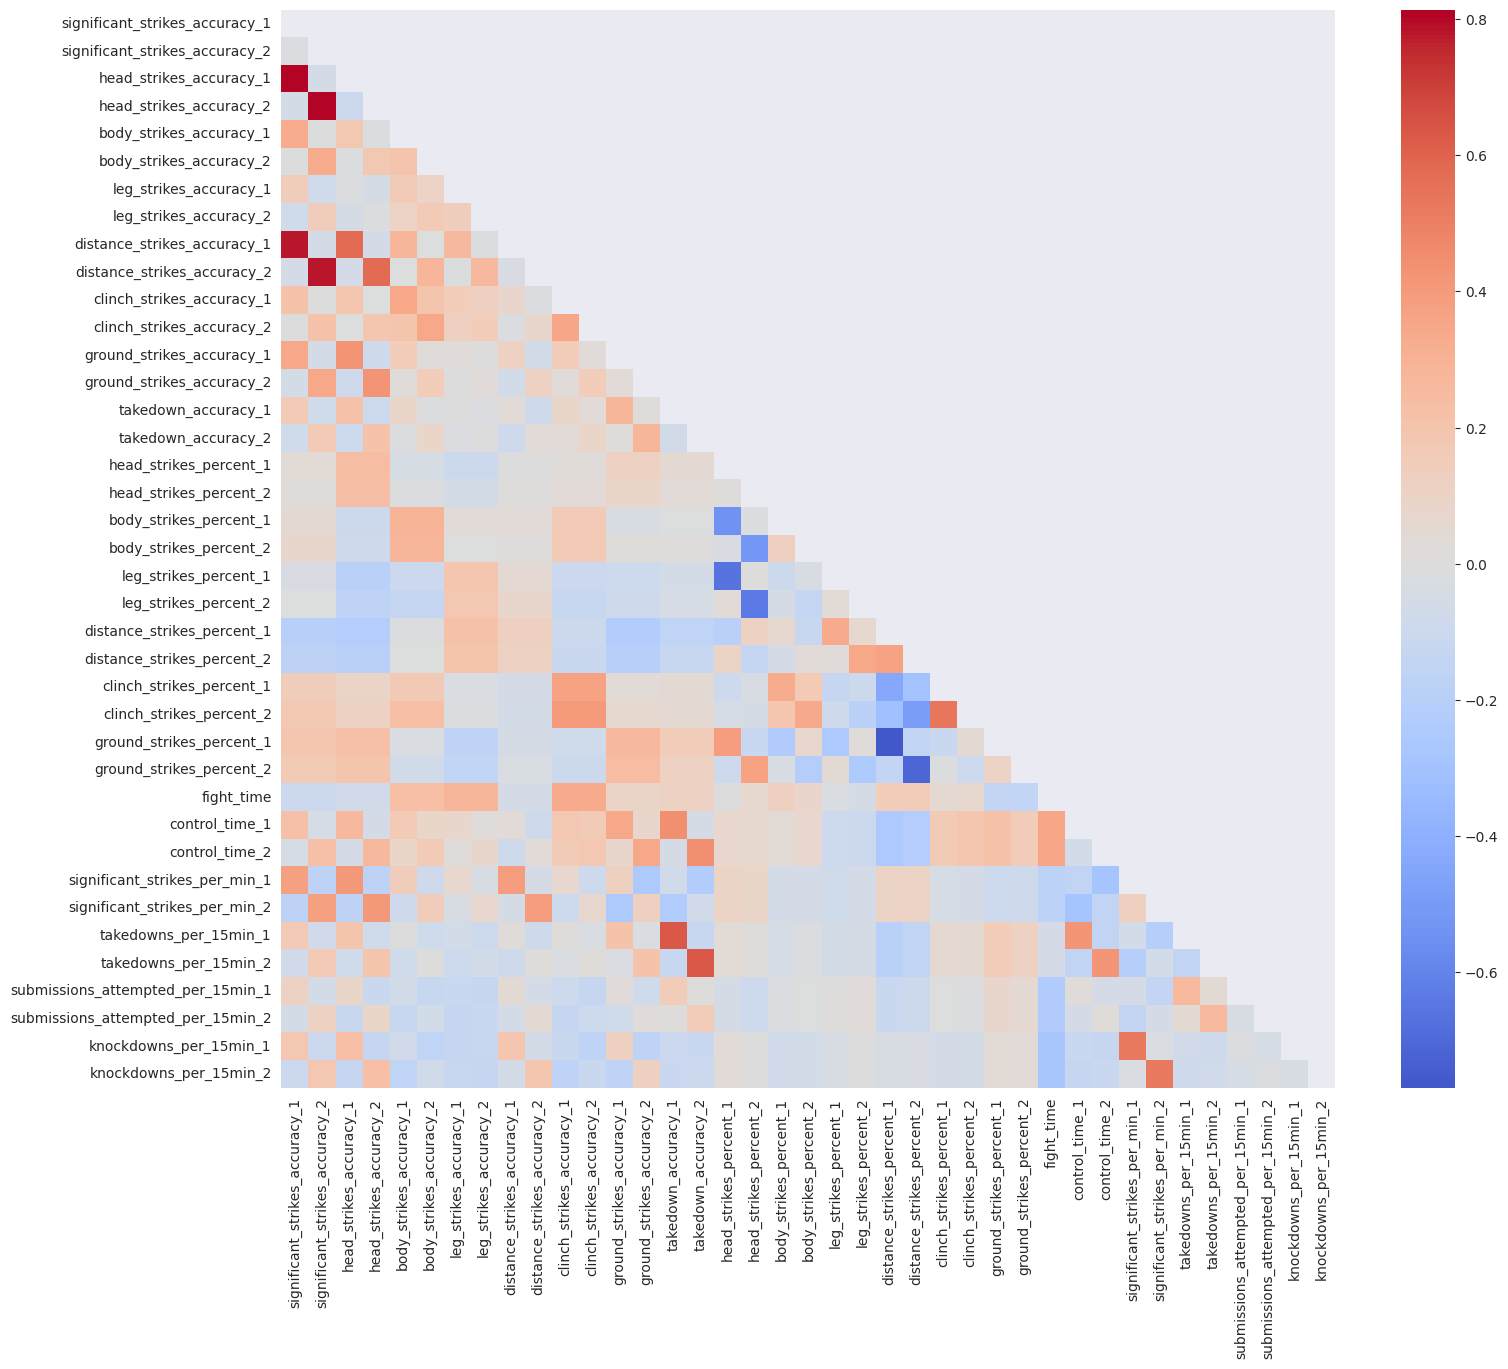

In [3]:
# correlation

num_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(17, 14))
sns.heatmap(data=num_df.corr(), cmap='coolwarm', center=0, mask=np.triu(num_df.corr()))

In [4]:
# total number of unique fighters
len(set(df.fighter_1.unique()))

1339

In [5]:
# separate dataframe for analysis, fights are repeated so we can use one fighter column

df1 = df.loc[:, ['fighter_1']]
df1.rename(columns={'fighter_1': 'fighter'}, inplace=True)
df1['fight_time_mins'] = df['fight_time'] / 60.0
df1.columns

Index(['fighter', 'fight_time_mins'], dtype='object')

In [6]:
# leg kickers (landing leg kicks most frequently)
df1['total_leg_strikes'] = df['leg_strikes_percent_1'] * df['significant_strikes_per_min_1'] * df1['fight_time_mins']
df1['total_leg_strikes'] = df1['total_leg_strikes'].apply(lambda x: round(x))

# accurate volume strikers (landing significant strikes most frequently)
df1['total_significant_strikes'] = df['significant_strikes_per_min_1'] * df1['fight_time_mins']
df1['total_significant_strikes'] = df1['total_significant_strikes'].apply(lambda x: round(x))

# takedown artist (landing takedowns most frequently)
df1['total_takedowns'] = df['takedowns_per_15min_1'] * df1['fight_time_mins'] / 15
df1['total_takedowns'] = df1['total_takedowns'].apply(round)

# power striker (most knockdowns generated per strike)
df1['total_knockdowns'] = df['knockdowns_per_15min_1'] * df1['fight_time_mins'] / 15
df1['total_knockdowns'] = df1['total_knockdowns'].apply(lambda x: round(x))

# hard to hit (largest proportion of failed significant strike attempts from opponents)
df1['total_significant_absorbed_strikes'] = df['significant_strikes_per_min_2'] * df1['fight_time_mins']
df1['total_significant_absorbed_strikes'] = df1['total_significant_absorbed_strikes'].apply(lambda x: round(x))
df1['total_significant_strikes_faced'] = df1['total_significant_absorbed_strikes'] / df['significant_strikes_accuracy_2'].apply(lambda x: float('inf') if x==0 else x)
df1['total_significant_strikes_faced'] = df1['total_significant_strikes_faced'].apply(lambda x: round(x))

# never goes down (largest proportion of failed takedown attempts from opponents)
df1['total_takedowns_conceded'] = df['takedowns_per_15min_2'] * df1['fight_time_mins'] / 15
df1['total_takedowns_conceded'] = df1['total_takedowns_conceded'].apply(lambda x: round(x))
df1['total_takedown_attempts_faced'] = df1['total_takedowns_conceded'] / df['takedown_accuracy_2'].apply(lambda x: float('inf') if x==0 else x)
df1['total_takedown_attempts_faced'] = df1['total_takedown_attempts_faced'].apply(lambda x: round(x))

# control_freak (largest proportion of control time out of total fight time)
df1['control_time_mins'] = df['control_time_1'] / 60


df1 = df1.groupby(by=['fighter'], as_index=False).sum()
df1['leg_strikes_per_min'] = df1['total_leg_strikes'] / df1['fight_time_mins']
df1['significant_strikes_per_min'] = df1['total_significant_strikes'] / df1['fight_time_mins']
df1['takedowns_per_min'] = df1['total_takedowns'] / df1['fight_time_mins']
df1['knockdowns_per_strike'] = df1['total_knockdowns'] / df1['total_significant_strikes']
df1['striking_defense'] = 1 - df1['total_significant_absorbed_strikes'] / df1['total_significant_strikes_faced']
df1['takedown_defense'] = 1 - df1['total_takedowns_conceded'] / df1['total_takedown_attempts_faced']
df1['control_time_percent'] = df1['control_time_mins'] / df1['fight_time_mins']

# excluding fighters with less than an hour of fight time for a fair representation of a fighter's skills
df1 = df1[df1['fight_time_mins'] >= 60]

In [7]:
df1.loc[:, ["fighter", "fight_time_mins", "total_leg_strikes", "leg_strikes_per_min"]].sort_values(by=['leg_strikes_per_min'], ascending=False).head(10)

,fighter,fight_time_mins,total_leg_strikes,leg_strikes_per_min
113,Armen Petrosyan,60.000000,133,2.216667
1125,Sabina Mazo,92.083333,183,1.987330
257,Chris Gutierrez,103.233333,204,1.976106
985,Nathaniel Wood,114.533333,218,1.903376
635,Joanna Jedrzejczyk,175.516667,328,1.868768
863,Marcin Prachnio,74.450000,134,1.799866
664,Jon Jones,89.100000,141,1.582492
525,Ian Garry,67.300000,106,1.575037
656,John Makdessi,106.666667,168,1.575000
1007,Nordine Taleb,63.100000,93,1.473851


In [8]:
df1.loc[:, ["fighter", "fight_time_mins", "total_significant_strikes", "significant_strikes_per_min"]].sort_values(by=['significant_strikes_per_min'], ascending=False).head(10)

,fighter,fight_time_mins,total_significant_strikes,significant_strikes_per_min
223,Casey O'Neill,61.366667,538,8.766974
906,Max Holloway,274.283333,2232,8.137571
1146,Sean O'Malley,92.566667,709,7.659345
1164,Shane Burgos,140.500000,1040,7.402135
719,Justin Gaethje,117.166667,861,7.348506
324,Daniel Rodriguez,106.300000,777,7.309501
156,Billy Quarantillo,104.200000,756,7.255278
161,Bobby Green,178.450000,1251,7.010367
569,Jamahal Hill,71.833333,501,6.974478
294,Cristiane Justino,63.683333,434,6.814970


In [9]:
df1.loc[:, ["fighter", "fight_time_mins", "total_takedowns", "takedowns_per_min"]].sort_values(by=['takedowns_per_min'], ascending=False).head(10)

,fighter,fight_time_mins,total_takedowns,takedowns_per_min
558,Jacob Malkoun,60.300000,30,0.497512
95,Anthony Hernandez,61.200000,28,0.457516
918,Merab Dvalishvili,169.416667,74,0.436793
276,Cody Durden,65.400000,27,0.412844
287,Corey Anderson,72.350000,29,0.400829
1214,Tatiana Suarez,61.650000,24,0.389294
1247,Tony Gravely,87.700000,33,0.376283
296,Curtis Blaydes,140.933333,52,0.368969
1306,Wilson Reis,70.016667,25,0.357058
1327,Zabit Magomedsharipov,77.633333,27,0.347789


In [10]:
df1.loc[:, ["fighter", "total_significant_strikes", "total_knockdowns", "knockdowns_per_strike"]].sort_values(by=['knockdowns_per_strike'], ascending=False).head(10)

,fighter,total_significant_strikes,total_knockdowns,knockdowns_per_strike
445,Francis Ngannou,160,7,0.043750
763,Khalil Rountree Jr.,332,12,0.036145
963,Montel Jackson,314,10,0.031847
4,Abdul Razak Alhassan,264,8,0.030303
351,Deiveson Figueiredo,379,11,0.029024
1225,Teruto Ishihara,180,5,0.027778
563,Jairzinho Rozenstruik,258,7,0.027132
1265,Tyson Pedro,199,5,0.025126
902,Matthew Semelsberger,419,10,0.023866
82,Andre Soukhamthath,266,6,0.022556


In [11]:
df1.loc[:, ["fighter", "total_significant_strikes_faced", "total_significant_absorbed_strikes", "striking_defense"]].sort_values(by=['striking_defense'], ascending=False).head(10)

,fighter,total_significant_strikes_faced,total_significant_absorbed_strikes,striking_defense
352,Demetrious Johnson,405,104,0.743210
950,Miles Johns,703,191,0.728307
16,Aiemann Zahabi,751,208,0.723036
329,Danielle Taylor,876,248,0.716895
856,Mara Romero Borella,561,163,0.709447
853,Manon Fiorot,839,255,0.696067
417,Enrique Barzola,1342,412,0.692996
365,Desmond Green,752,233,0.690160
543,Ismail Naurdiev,246,78,0.682927
712,Julio Arce,1128,360,0.680851


In [12]:
# takedown defense is only really tested when considerable amount of attempts are made against the fighter
td_df1 = df1[df1['total_takedown_attempts_faced'] >= 30]
td_df1.loc[:, ["fighter", "total_takedown_attempts_faced", "total_takedowns_conceded", "takedown_defense"]].sort_values(by=['takedown_defense'], ascending=False).head(10)

,fighter,total_takedown_attempts_faced,total_takedowns_conceded,takedown_defense
797,Leonardo Santos,31,4,0.870968
1164,Shane Burgos,39,6,0.846154
728,Kai Kara-France,38,6,0.842105
1150,Sean Woodson,38,6,0.842105
906,Max Holloway,48,8,0.833333
1037,Petr Yan,92,17,0.815217
748,Kennedy Nzechukwu,55,11,0.800000
172,Brad Tavares,35,7,0.800000
379,Dominick Reyes,34,7,0.794118
1131,Sam Alvey,45,10,0.777778


In [13]:
df1.loc[:, ["fighter", "fight_time_mins", "control_time_mins", "control_time_percent"]].sort_values(by=['control_time_percent'], ascending=False).head(10)

,fighter,fight_time_mins,control_time_mins,control_time_percent
1214,Tatiana Suarez,61.650000,43.516667,0.705866
492,Grant Dawson,100.333333,65.166667,0.649502
1137,Sara McMann,70.683333,42.950000,0.607640
647,Joe Solecki,73.766667,44.233333,0.599638
558,Jacob Malkoun,60.300000,35.733333,0.592593
759,Khabib Nurmagomedov,89.233333,51.850000,0.581061
276,Cody Durden,65.400000,36.933333,0.564730
953,Mirsad Bektic,66.233333,37.016667,0.558883
426,Erin Blanchfield,62.866667,34.633333,0.550901
95,Anthony Hernandez,61.200000,33.266667,0.543573


In [14]:
# all out brawl (highest significant strikes landed total in a fight from both fighters)

df['total_significant_strikes_landed_both'] = (df['significant_strikes_per_min_1'] + df['significant_strikes_per_min_2']) * df['fight_time'] / 60 
df['total_significant_strikes_landed_both'] = df['total_significant_strikes_landed_both'].apply(lambda x: round(x))

# since we have duplicates of all the fights, when sorted, we must pick only alternate the rows from the sorted dataframe
brawl_df = df.loc[:, ['fighter_1', 'significant_strikes_per_min_1', 'total_significant_strikes_landed_both', 'significant_strikes_per_min_2', 'fighter_2']].sort_values(by='total_significant_strikes_landed_both', ascending=False)
brawl_df.iloc[0::2, :].head(10)

,fighter_1,significant_strikes_per_min_1,total_significant_strikes_landed_both,significant_strikes_per_min_2,fighter_2
1384,Max Holloway,17.800000,578,5.320000,Calvin Kattar
730,Rob Font,10.840000,430,6.360000,Marlon Vera
5848,Brian Ortega,5.500000,400,14.500000,Max Holloway
3641,Jared Cannonier,9.640000,394,6.120000,Marvin Vettori
4433,Yair Rodriguez,6.360000,389,9.200000,Max Holloway
5688,Dustin Poirier,7.120000,359,7.240000,Max Holloway
4447,Billy Quarantillo,10.933333,357,12.866667,Shane Burgos
4472,Marvin Vettori,7.600000,353,6.520000,Paulo Costa
1757,Zhang Weili,6.600000,351,7.440000,Joanna Jedrzejczyk
4340,Casey O'Neill,15.266667,349,8.000000,Roxanne Modafferi


## Predicting fight results and fight ending period

In [15]:
# separating data for result prediction & over-under prediction

numeric_columns = list(df.select_dtypes(include=['float64', 'int64']).columns)
df_X = df.loc[:, numeric_columns]
df_Y_results = df.loc[:, ['result']]['result'].tolist()
df_Y_over_under = df.loc[:, ['two_n_half']]['two_n_half'].tolist()

### Models

In [ ]:
# Random Forest Classifier

max_samples_size = 500
estimators = np.arange(60, 251, 20)
max_depths = np.arange(4, 24, 2)
mesh_e, mesh_md = np.meshgrid(estimators, max_depths)
mesh_rf = np.vstack( (mesh_e.flatten(), mesh_md.flatten()) ).T

# record average accuracy from cross validation scores for both tasks
rf_scores_1, rf_scores_2 = [], []

for e, md in mesh_rf:
  clf = RandomForestClassifier(n_estimators=e, max_depth=md, bootstrap=True, max_samples=max_samples_size)
  rf_scores_1.append( np.mean(cross_val_score(clf, X=df_X, y=df_Y_results, cv=5)) )
  rf_scores_2.append( np.mean(cross_val_score(clf, X=df_X, y=df_Y_over_under, cv=5)) )

In [ ]:
# Multi-layer Perceptron (2 hidden layers)

learning_rates = np.linspace(0.01, 0.0001, 10)
hidden_layer_sizes = np.arange(6, 26, 2)
mesh_lr, mesh_hl = np.meshgrid(learning_rates, hidden_layer_sizes)
mesh_mlp = np.vstack( (mesh_lr.flatten(), mesh_hl.flatten()) ).T

mlp_scores_1, mlp_scores_2 = [], []

for lr, hl in mesh_mlp:
  hl = int(hl)
  clf = MLPClassifier(hidden_layer_sizes=(hl, hl), activation='logistic', solver='adam', learning_rate_init=lr)
  mlp_scores_1.append( np.mean(cross_val_score(clf, X=df_X, y=df_Y_results, cv=5)) )
  mlp_scores_2.append( np.mean(cross_val_score(clf, X=df_X, y=df_Y_over_under, cv=5)) )

### Visualization

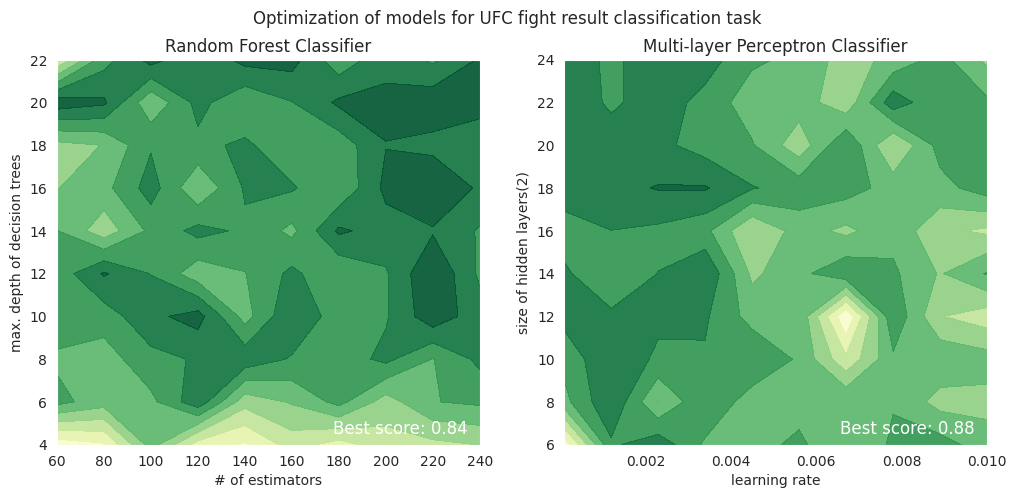

In [98]:
# for fight result

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

rf_scores_1 = np.array(rf_scores_1).reshape(mesh_e.shape)
axs[0].contourf(mesh_e, mesh_md, rf_scores_1, cmap='YlGn', alpha=0.9)
axs[0].set_xlabel("# of estimators")
axs[0].set_ylabel("max. depth of decision trees")
axs[0].set_title("Random Forest Classifier")
axs[0].text(mesh_e.max() - 5, mesh_md.min() + .5, f'Best score: {rf_scores_1.max():.2f}'.lstrip('0'), size=12, horizontalalignment='right', c='white')

mlp_scores_1 = np.array(mlp_scores_1).reshape(mesh_lr.shape)
axs[1].contourf(mesh_lr, mesh_hl, mlp_scores_1, cmap='YlGn', alpha=0.9)
axs[1].set_xlabel("learning rate")
axs[1].set_ylabel("size of hidden layers(2)")
axs[1].set_title("Multi-layer Perceptron Classifier")
axs[1].text(mesh_lr.max() - 3e-4, mesh_hl.min() + 0.5, f'Best score: {mlp_scores_1.max():.2f}'.lstrip('0'), size=12, horizontalalignment='right', c='white')

fig.suptitle('Optimization of models for UFC fight result classification task')
plt.show()

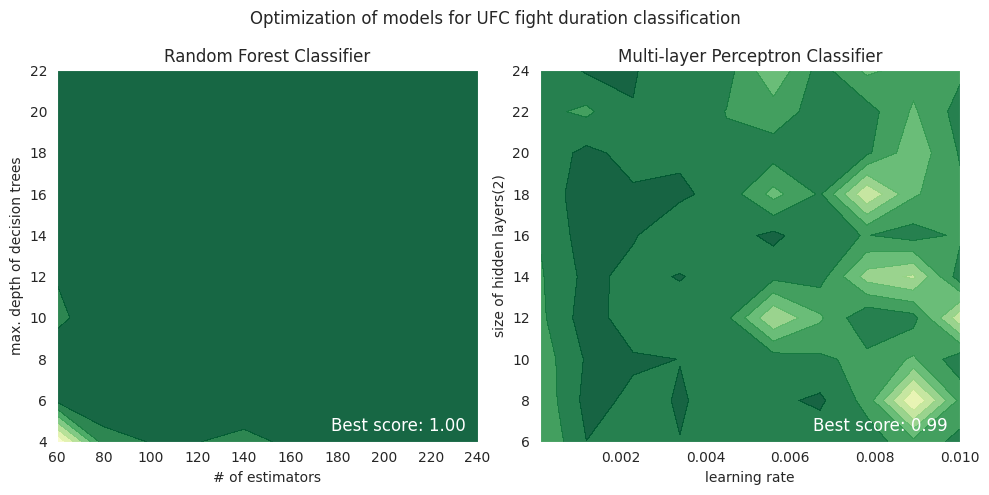

In [97]:
# for over-under prediction

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

rf_scores_2 = np.array(rf_scores_2).reshape(mesh_e.shape)
axs[0].contourf(mesh_e, mesh_md, rf_scores_2, cmap='YlGn', alpha=0.9)
axs[0].set_xlabel("# of estimators")
axs[0].set_ylabel("max. depth of decision trees")
axs[0].set_title("Random Forest Classifier")
axs[0].text(mesh_e.max() - 5, mesh_md.min() + .5, f'Best score: {rf_scores_2.max():.2f}'.lstrip('0'), size=12, horizontalalignment='right', c='white')

mlp_scores_2 = np.array(mlp_scores_2).reshape(mesh_lr.shape)
axs[1].contourf(mesh_lr, mesh_hl, mlp_scores_2, cmap='YlGn', alpha=0.9)
axs[1].set_xlabel("learning rate")
axs[1].set_ylabel("size of hidden layers(2)")
axs[1].set_title("Multi-layer Perceptron Classifier")
axs[1].text(mesh_lr.max() - 3e-4, mesh_hl.min() + 0.5, f'Best score: {mlp_scores_2.max():.2f}'.lstrip('0'), size=12, horizontalalignment='right', c='white')

fig.suptitle('Optimization of models for UFC fight duration classification')
plt.tight_layout()
plt.show()